In [1]:
import pandas as pd

import config
import tqdm

In [133]:
def determine_if_row_is_control(row: pd.Series, control_df: pd.DataFrame) -> bool:
    """Given a row in the MTurk results dataframe, determine if this is a control trial"""

    if "All" in row["premises"][0]:
        return True

    control_rows = control_df[(control_df["conclusion_type"] == row["conclusion_type"]) & (control_df["domain"] == row["domain"]) & (control_df["is_single_premise"] == row["is_single_premise"])]
    
    for _, control_row in control_rows.iterrows():
        control_premise = tuple(control_row["premises"])
        control_conclusion = control_row["conclusion"]
        if tuple(control_premise) == row["premises"] and control_conclusion == row["conclusion"]:
            return True

    return False


def identify_participants_to_cut(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identify participants that we should exclude from our analysis.
    
    'Light cut': participants who got more than one control trial incorrect.
    'Medium cut': Same as above, or those who gave at least 12 trials the exact same rating.
    'Hard cut': Same as above, or those who gave at least 8 trials the exact same rating.
    """

    rows = []
    for pid, pid_df in df.groupby("pid"):

        num_incorrect_controls = pid_df[(pid_df["is_control"]) & (pid_df["rating"] < 50)].shape[0]
        ratings_range = pid_df["rating"].max() - pid_df["rating"].min()
        ratings_mode = pid_df["rating"].value_counts().max()
        ratings_std = pid_df["rating"].std()

        rows.append((pid, num_incorrect_controls, ratings_range, ratings_mode, ratings_std))

    pid_cut_df = pd.DataFrame(rows, columns=["pid", "num_incorrect_controls", "ratings_range", "ratings_mode", "ratings_std"])
    pid_cut_df["light_cut"] = [row["num_incorrect_controls"] > 1 for _, row in pid_cut_df.iterrows()]
    pid_cut_df["medium_cut"] = [row["ratings_mode"] >= 12 or row["num_incorrect_controls"] > 1 for _, row in pid_cut_df.iterrows()]
    pid_cut_df["hard_cut"] = [row["ratings_mode"] >= 8 or row["num_incorrect_controls"] > 1 for _, row in pid_cut_df.iterrows()]

    output_df = df.merge(pid_cut_df[["pid", "light_cut", "medium_cut", "hard_cut"]], on="pid")
    assert output_df.shape[0] == df.shape[0]
    
    for cut_type in ("light_cut", "medium_cut", "hard_cut"):
        print(f"Number of {cut_type} participants: {pid_cut_df[pid_cut_df[cut_type]].shape[0]}/{pid_cut_df.shape[0]}")
    print()

    return output_df

In [143]:
# Load original experiment split labels
experiment_df = pd.read_csv(f"{config.DATA}/experiment_trials.csv", index_col=0)
experiment_df["pid"] = experiment_df["pid"].apply(str)
experiment_df["tid"] = experiment_df["tid"].apply(str)
experiment_df["premises"] = experiment_df["premises"].apply(lambda x: tuple(eval(x)))
experiment_df = experiment_df[experiment_df["is_osherson"] == 0].reset_index(drop=True)

# Load human ratings
human_df = pd.read_csv(f"{config.DATA}/raw_human_ratings.csv")
human_df["pid"] = human_df["tid"].apply(lambda x: x.split("participant")[-1])
human_df["tid"] = human_df["trialId"].apply(lambda x: x.replace("tc", ""))
human_df["premises"] = human_df["premises0"].apply(lambda x: tuple(x.split(":")))
human_df["conclusion"] = human_df["conclusion0"]
human_df["conclusion_type"] = human_df["conclusionType"].apply(lambda x: x.capitalize())

# Drop participants who were not paid
unpaid_participants_df = pd.read_csv(f"{config.DATA}/unpaid_participants.csv", index_col=0)
drop_uids = unpaid_participants_df[~unpaid_participants_df["paid"]]["uid"].tolist()
human_df = human_df[~human_df["uid"].isin(drop_uids)].reset_index(drop=True)

# Join human_df and experiment_df, keeping experiment_df's split labels
df = human_df.merge(experiment_df, on=["pid", "tid", "conclusion_type", "premises", "conclusion"])
df["is_single_premise"] = df["premises"].apply(lambda x: len(x) == 1)
df = df[["pid", "tid", "domain", "conclusion_type", "is_single_premise", "premises", "conclusion", "rating"]].sort_values(by=["pid", "tid"]).reset_index(drop=True)

# Do some checks
print(f"Merged df nrows: {df.shape[0]}, human_df nrows: {human_df.shape[0]}, experiment_df nrows: {experiment_df.shape[0]}")
print(f"Total number of PIDs: {len(human_df['pid'].unique())}")
missing_pids = set(experiment_df["pid"]).difference(set(human_df["pid"]))
print(f"Missing PIDs that are in experiment_df but not human_df: {missing_pids}")
assert df.shape[0] == human_df.shape[0] == experiment_df[~experiment_df["pid"].isin(missing_pids)].shape[0]
assert len(experiment_df["pid"].unique()) == len(df["pid"].unique()) + len(missing_pids)
assert all(gdf.shape[0] == 38 for _,gdf in df.groupby("pid"))
print()

# Label control trials
control_df = pd.read_csv(f"{config.DATA}/control_trials.csv", index_col=0)
control_df["premises"] = control_df["premises"].apply(lambda x: tuple(eval(x)))
print("Labelling trials as control or not control...")
df["is_control"] = [determine_if_row_is_control(row, control_df) for _, row in tqdm.tqdm(df.iterrows())]
assert all(p == 4 for p in df[df["is_control"]]["pid"].value_counts().tolist())
assert df[df["is_control"]]["pid"].value_counts().shape[0] == len(df["pid"].unique())

df = identify_participants_to_cut(df)
df["argument"] = [(row["premises"], row["conclusion"]) for _, row in df.iterrows()]
df = df[["pid", "tid",  "argument", "domain", "conclusion_type", "is_single_premise", "is_control", "premises", "conclusion", "rating", "light_cut", "medium_cut", "hard_cut"]]

134it [00:00, 1339.99it/s]

Merged df nrows: 23028, human_df nrows: 23028, experiment_df nrows: 23180
Total number of PIDs: 606
Missing PIDs that are in experiment_df but not human_df: {'58', '526', '381', '538'}

Labelling trials as control or not control...


23028it [00:18, 1260.85it/s]


Number of light_cut participants: 86/606
Number of medium_cut participants: 152/606
Number of hard_cut participants: 210/606



In [144]:
df.head()

,pid,tid,argument,domain,conclusion_type,is_single_premise,is_control,premises,conclusion,rating,light_cut,medium_cut,hard_cut
0,0,0,"((Eagles,), All birds)",Birds,General,True,False,"(Eagles,)",All birds,0,False,False,False
1,0,1,"((Crows,), All birds)",Birds,General,True,False,"(Crows,)",All birds,7,False,False,False
2,0,10,"((Vultures,), All birds)",Birds,General,True,False,"(Vultures,)",All birds,3,False,False,False
3,0,11,"((Falcons,), All birds)",Birds,General,True,False,"(Falcons,)",All birds,3,False,False,False
4,0,12,"((Herons,), All birds)",Birds,General,True,False,"(Herons,)",All birds,7,False,False,False


In [157]:
df = df[~df["medium_cut"]]
print(f"Number of participants left after medium cut: {len(df['pid'].unique())}")

df["ratings_rank"] = df.groupby(["pid", "is_single_premise"])['rating'].rank("dense", ascending=False)

rows = []
argument_labels = ["argument", "domain", "conclusion_type", "is_single_premise", "is_control", "premises", "conclusion"]
for al, arg_df in df.groupby(argument_labels):

    avg_rank = arg_df["ratings_rank"].mean()
    avg_rating = arg_df["rating"].mean()

    num_ratings = arg_df.shape[0]

    rows.append(al + (avg_rating, avg_rank, num_ratings))
    
aggregated_df = pd.DataFrame(rows, columns=argument_labels + ["average_rating", "average_ranking", "num_ratings"])
aggregated_df = aggregated_df[~aggregated_df["is_control"]].reset_index(drop=True)

# Check that number of arguments is correct and all are unique
for split, split_df in aggregated_df.groupby(["domain", "conclusion_type", "is_single_premise"]):
    domain, conclusion_type, is_single_premise = split
    if conclusion_type == "General":
        assert split_df.shape[0] == 24 if is_single_premise else split_df.shape[0] == 100
    else:
        assert split_df.shape[0] > 100 if is_single_premise else split_df.shape[0] == 100
    assert len(set(split_df["argument"].tolist())) == split_df.shape[0]
    
# Print statistics on number of arguments per split
print("Number of ratings per argument per split")
for split, split_df in aggregated_df.groupby(["domain", "conclusion_type", "is_single_premise"]):
    r = split_df["num_ratings"]
    minr, maxr, meanr, sdr = r.min(), r.max(), r.mean(), r.std()
    print(f"    {split}: min - {minr}, max - {maxr}, mean - {meanr:.2f}, sd - {sdr:.2f}")

Number of participants left after medium cut: 454
Number of ratings per argument per split
    ('Birds', 'General', False): min - 4, max - 13, mean - 6.50, sd - 2.13
    ('Birds', 'General', True): min - 65, max - 65, mean - 65.00, sd - 0.00
    ('Birds', 'Specific', False): min - 7, max - 10, mean - 8.50, sd - 0.81
    ('Birds', 'Specific', True): min - 7, max - 34, mean - 12.29, sd - 5.59
    ('Mammals', 'General', False): min - 4, max - 8, mean - 5.80, sd - 1.33
    ('Mammals', 'General', True): min - 58, max - 58, mean - 58.00, sd - 0.00
    ('Mammals', 'Specific', False): min - 8, max - 10, mean - 8.90, sd - 0.83
    ('Mammals', 'Specific', True): min - 8, max - 36, mean - 13.43, sd - 6.52
    ('Vehicles', 'General', False): min - 4, max - 8, mean - 6.60, sd - 1.29
    ('Vehicles', 'General', True): min - 66, max - 66, mean - 66.00, sd - 0.00
    ('Vehicles', 'Specific', False): min - 7, max - 10, mean - 9.10, sd - 1.14
    ('Vehicles', 'Specific', True): min - 7, max - 35, mean -

In [153]:
aggregated_df

,argument,domain,conclusion_type,is_single_premise,is_control,premises,conclusion,average_rating,average_ranking,num_ratings
0,"((Airplanes,), All vehicles)",Vehicles,General,True,False,"(Airplanes,)",All vehicles,38.136364,9.257576,66
1,"((Airplanes,), Bicycles)",Vehicles,Specific,True,False,"(Airplanes,)",Bicycles,22.285714,14.142857,7
2,"((Airplanes,), Helicopters)",Vehicles,Specific,True,False,"(Airplanes,)",Helicopters,77.875000,4.750000,8
3,"((Airplanes,), Jeeps)",Vehicles,Specific,True,False,"(Airplanes,)",Jeeps,34.250000,14.250000,8
4,"((Airplanes,), Skateboards)",Vehicles,Specific,True,False,"(Airplanes,)",Skateboards,23.187500,14.625000,16
...,...,...,...,...,...,...,...,...,...,...
1156,"((Zeppelins, Rockets), All vehicles)",Vehicles,General,False,False,"(Zeppelins, Rockets)",All vehicles,56.142857,7.000000,7
1157,"((Zeppelins, Sleds), Caravans)",Vehicles,Specific,False,False,"(Zeppelins, Sleds)",Caravans,53.250000,6.250000,8
1158,"((Zeppelins, Submarines), All vehicles)",Vehicles,General,False,False,"(Zeppelins, Submarines)",All vehicles,47.333333,6.666667,6
1159,"((Zeppelins, Tractors), All vehicles)",Vehicles,General,False,False,"(Zeppelins, Tractors)",All vehicles,51.000000,4.625000,8


# Test rerun

In [21]:
import seaborn as sns

2842


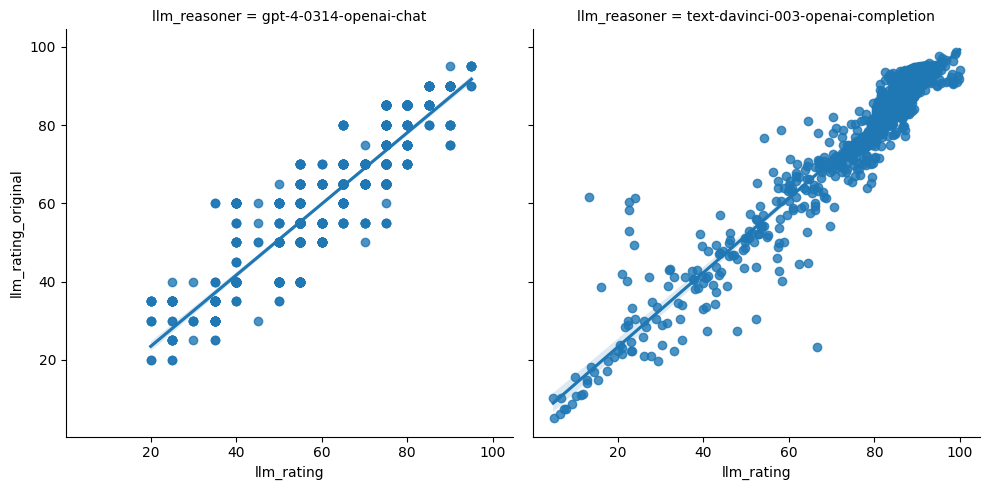

In [30]:
df1 = pd.read_csv("../data/experiment_2/llm_ratings.csv", index_col=0)
df2 = pd.read_csv("../data/experiment_2/model_ratings.csv", index_col=0)
df2 = df2[df2["prompt_generator"] == "S3-C1-A1-Q1-O1-T"]

rows = []
for _, row in df2.iterrows():
    rows.append(("text-davinci-003-openai-completion", row["argument_id"], row["gpt3_rating"]))
    rows.append(("gpt-4-0314-openai-chat", row["argument_id"], row["gpt4_rating"]))
df2 = pd.DataFrame(rows, columns=["llm_reasoner", "argument", "llm_rating_original"])
df1 = df1[["llm_reasoner", "argument", "llm_rating"]].dropna()

print(len(df1))

jdf = df1.merge(df2, on=["llm_reasoner", "argument"])
sns.lmplot(x="llm_rating", y="llm_rating_original", col="llm_reasoner", data=jdf)


In [31]:
df1 = pd.read_csv("../data/experiment_2/llm_ratings.csv", index_col=0)


In [36]:
df1[df1["llm_reasoner"] == "
    "].shape[0]

1161

In [37]:
df1[df1["llm_reasoner"] == "gpt-3.5-turbo-0613-openai-chat"].dropna().shape[0]

520

In [2]:
import llms

In [3]:
df1 = pd.read_csv("../data/experiment_2/llm_ratings.csv", index_col=0)
df1["llm_rating"] = df1["llm_raw_completion"].apply(lambda x: llms.LLMReasoner.parse_e2_response(x))
df1.to_csv("../data/experiment_2/llm_ratings.csv")

/Users/jerome/anaconda3/envs/research/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [4]:
for _, row in df1.iterrows():
    print(row["llm_raw_completion"])
    print(row["llm_rating"])
    print()

Given the fact that airplanes have property P, it is possible that the claim "All vehicles have property P" is true. However, without further information about other types of vehicles, it is difficult to determine the likelihood with certainty. I would rate the likelihood as 50 out of 100.
50.0

0
0.0

100
100.0

20
20.0

20
20.0

20
20.0

0
0.0

Given the facts presented, it is difficult to determine the likelihood of the claim being true without more information. The fact that airplanes and buses have property P suggests that there is a possibility that all vehicles have property P. However, without additional information about other types of vehicles, it is uncertain whether the claim is true or not. I would rate it as 50, indicating a neutral stance.
50.0

Given the facts presented, it is not possible to determine the likelihood of the claim being true. I would rate it as 50. While it is true that airplanes and helicopters have property P, it does not necessarily mean that all vehi

In [54]:
df35 = pd.read_csv("/Users/jerome/Desktop/llm_ratings_gpt35.csv", index_col=0)
df3 = pd.read_csv("/Users/jerome/Desktop/llm_ratings_gpt3.csv", index_col=0)
df4 = pd.read_csv("/Users/jerome/Desktop/llm_ratings_gpt4.csv", index_col=0)

df4 = df4[df4["prompt_generator"] == "S3-C1-A1-Q4-O1-T"]
args = set(df3["argument"])
df4 = df4[df4["argument"].isin(args)]

assert set(df3["argument"]) == set(df4["argument"])

df4["llm_reasoner"] = ["gpt-4-0314-openai-chat"] * len(df4)
df4["llm_model"] = ["gpt-4-0314"] * len(df4)

control_df = df35[["argument", "is_control", "conclusion_type", "is_single_premise"]]
df4 = df4.merge(control_df, on="argument")
df4["llm_raw_completion"] = df4["completion"]
df4["prompt"] = df4["message"]
df4["llm_rating"] = df4["parsed_answer"]

l = len(df4)
df4 = df4[df35.columns]
assert len(df4) == l

df = pd.concat([df3,df35,df4], ignore_index=True)
df.to_csv("../data/experiment_2/llm_ratings.csv")

In [49]:
df4

,prompt_generator,argument,premises,conclusion,domain,message,completion,completion_full,parsed_answer,llm_reasoner,llm_model,is_control,conclusion_type,is_single_premise
0,S3-C1-A1-Q4-O1-T,"(('Airplanes', 'Buses'), 'All vehicles')","['Airplanes', 'Buses']",All vehicles,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",70,"{\n ""choices"": [\n {\n ""finish_reason...",70,gpt-4-0314-openai-chat,gpt-4-0314,False,General,False
1,S3-C1-A1-Q4-O1-T,"(('Airplanes', 'Helicopters'), 'All vehicles')","['Airplanes', 'Helicopters']",All vehicles,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",55,"{\n ""choices"": [\n {\n ""finish_reason...",55,gpt-4-0314-openai-chat,gpt-4-0314,False,General,False
2,S3-C1-A1-Q4-O1-T,"(('Airplanes', 'Taxis'), 'All vehicles')","['Airplanes', 'Taxis']",All vehicles,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",70,"{\n ""choices"": [\n {\n ""finish_reason...",70,gpt-4-0314-openai-chat,gpt-4-0314,False,General,False
3,S3-C1-A1-Q4-O1-T,"(('Airplanes', 'Trams'), 'Trains')","['Airplanes', 'Trams']",Trains,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",85,"{\n ""choices"": [\n {\n ""finish_reason...",85,gpt-4-0314-openai-chat,gpt-4-0314,False,Specific,False
4,S3-C1-A1-Q4-O1-T,"(('Airplanes', 'Zeppelins'), 'All vehicles')","['Airplanes', 'Zeppelins']",All vehicles,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",50,"{\n ""choices"": [\n {\n ""finish_reason...",50,gpt-4-0314-openai-chat,gpt-4-0314,False,General,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,S3-C1-A1-Q4-O1-T,"(('Zeppelins',), 'Buses')",['Zeppelins'],Buses,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",Given that zeppelins and buses are both modes ...,"{\n ""choices"": [\n {\n ""finish_reason...",40,gpt-4-0314-openai-chat,gpt-4-0314,False,Specific,True
1157,S3-C1-A1-Q4-O1-T,"(('Zeppelins',), 'Caravans')",['Zeppelins'],Caravans,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",Given that zeppelins and caravans are both mod...,"{\n ""choices"": [\n {\n ""finish_reason...",40,gpt-4-0314-openai-chat,gpt-4-0314,False,Specific,True
1158,S3-C1-A1-Q4-O1-T,"(('Zeppelins',), 'Mopeds')",['Zeppelins'],Mopeds,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",Given that zeppelins and mopeds are both modes...,"{\n ""choices"": [\n {\n ""finish_reason...",30,gpt-4-0314-openai-chat,gpt-4-0314,False,Specific,True
1159,S3-C1-A1-Q4-O1-T,"(('Zeppelins',), 'Skateboards')",['Zeppelins'],Skateboards,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",Given that zeppelins and skateboards are very ...,"{\n ""choices"": [\n {\n ""finish_reason...",20,gpt-4-0314-openai-chat,gpt-4-0314,False,Specific,True


In [38]:
df3.head(2)

,llm_reasoner,llm_model,argument,domain,conclusion_type,is_single_premise,is_control,premises,conclusion,prompt,llm_raw_completion,llm_rating
0,text-davinci-003-openai-completion,text-davinci-003,"(('Trams', 'Jeeps'), 'All vehicles')",Vehicles,General,False,False,"['Trams', 'Jeeps']",All vehicles,You are an expert on objects and the types of ...,"{\n ""id"": ""cmpl-7UdGDzexyrN7IcrkIfg5Qll3RhRPx...",65.329936
1,text-davinci-003-openai-completion,text-davinci-003,"(('Taxis',), 'Mopeds')",Vehicles,Specific,True,False,['Taxis'],Mopeds,You are an expert on objects and the types of ...,"{\n ""id"": ""cmpl-7UdGCyrmWGzLGtvGCZChTupMwDmNW...",77.383367


In [39]:
df4.head(2)

,prompt_generator,argument,premises,conclusion,domain,message,completion,completion_full,parsed_answer
4,S3-C1-A1-Q4-O1-T,"(('Airplanes', 'Buses'), 'All vehicles')","['Airplanes', 'Buses']",All vehicles,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",70,"{\n ""choices"": [\n {\n ""finish_reason...",70
9,S3-C1-A1-Q4-O1-T,"(('Airplanes', 'Helicopters'), 'All vehicles')","['Airplanes', 'Helicopters']",All vehicles,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",55,"{\n ""choices"": [\n {\n ""finish_reason...",55


In [40]:
set(df3["argument"]) == set(df4["argument"])

True

In [46]:
df4["llm_reasoner"] = ["gpt-4-0314-openai-chat"] * len(df4)
df4["llm_model"] = ["gpt-4-0314"] * len(df4)

control_df = df35[["argument", "is_control", "conclusion_type", "is_single_premise"]]
df4 = df4.merge(control_df, on="argument")

df4[df35.columns]

KeyError: "['is_control', 'prompt', 'llm_raw_completion', 'llm_rating'] not in index"

In [47]:
df35.columns

Index(['llm_reasoner', 'llm_model', 'argument', 'domain', 'conclusion_type',
       'is_single_premise', 'is_control', 'premises', 'conclusion', 'prompt',
       'llm_raw_completion', 'llm_rating'],
      dtype='object')

In [44]:
df4

,prompt_generator,argument,premises,conclusion,domain,message,completion,completion_full,parsed_answer,llm_reasoner,llm_model
4,S3-C1-A1-Q4-O1-T,"(('Airplanes', 'Buses'), 'All vehicles')","['Airplanes', 'Buses']",All vehicles,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",70,"{\n ""choices"": [\n {\n ""finish_reason...",70,gpt-4-0314-openai-chat,gpt-4-0314
9,S3-C1-A1-Q4-O1-T,"(('Airplanes', 'Helicopters'), 'All vehicles')","['Airplanes', 'Helicopters']",All vehicles,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",55,"{\n ""choices"": [\n {\n ""finish_reason...",55,gpt-4-0314-openai-chat,gpt-4-0314
14,S3-C1-A1-Q4-O1-T,"(('Airplanes', 'Taxis'), 'All vehicles')","['Airplanes', 'Taxis']",All vehicles,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",70,"{\n ""choices"": [\n {\n ""finish_reason...",70,gpt-4-0314-openai-chat,gpt-4-0314
19,S3-C1-A1-Q4-O1-T,"(('Airplanes', 'Trams'), 'Trains')","['Airplanes', 'Trams']",Trains,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",85,"{\n ""choices"": [\n {\n ""finish_reason...",85,gpt-4-0314-openai-chat,gpt-4-0314
24,S3-C1-A1-Q4-O1-T,"(('Airplanes', 'Zeppelins'), 'All vehicles')","['Airplanes', 'Zeppelins']",All vehicles,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",50,"{\n ""choices"": [\n {\n ""finish_reason...",50,gpt-4-0314-openai-chat,gpt-4-0314
...,...,...,...,...,...,...,...,...,...,...,...
5949,S3-C1-A1-Q4-O1-T,"(('Zeppelins',), 'Buses')",['Zeppelins'],Buses,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",Given that zeppelins and buses are both modes ...,"{\n ""choices"": [\n {\n ""finish_reason...",40,gpt-4-0314-openai-chat,gpt-4-0314
5954,S3-C1-A1-Q4-O1-T,"(('Zeppelins',), 'Caravans')",['Zeppelins'],Caravans,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",Given that zeppelins and caravans are both mod...,"{\n ""choices"": [\n {\n ""finish_reason...",40,gpt-4-0314-openai-chat,gpt-4-0314
5959,S3-C1-A1-Q4-O1-T,"(('Zeppelins',), 'Mopeds')",['Zeppelins'],Mopeds,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",Given that zeppelins and mopeds are both modes...,"{\n ""choices"": [\n {\n ""finish_reason...",30,gpt-4-0314-openai-chat,gpt-4-0314
5964,S3-C1-A1-Q4-O1-T,"(('Zeppelins',), 'Skateboards')",['Zeppelins'],Skateboards,Vehicles,"[{'role': 'system', 'content': ""You are an exp...",Given that zeppelins and skateboards are very ...,"{\n ""choices"": [\n {\n ""finish_reason...",20,gpt-4-0314-openai-chat,gpt-4-0314
